   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.2 MB/s eta 0:00:00
PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4
Starting Cross-IoT DDoS Detection with FIXED Logic
Using device: cuda

Step 1: Loading and preprocessing data...
Loading datasets...
Original shapes: BoT-IoT: (11503556, 79), ToN-IoT: (4847499, 79)
After sampling: BoT-IoT: (575178, 79), ToN-IoT: (242375, 79)

BoT-IoT unique attacks: ['dos' 'ddos' 'reconnaissance' 'benign' 'theft']
ToN-IoT unique attacks: ['xss' 'benign' 'password' 'scanning' 'injection' 'backdoor' 'ransomware'
 'dos' 'mitm' 'ddos']

Class distributions:
BoT-IoT - DDoS: 478645, Benign: 96533
ToN-IoT - DDoS: 13, Benign: 242362

BoT-IoT Class Distribution:
Attack
ddos              239812
dos               238833
reconnaissance     94537
benign              1961
theft                 35
Name: count, dtype: int64
DDoS ratio: 0.8322

ToN-IoT Class Distribution:
Attack
benign        106130
xss           103050
password       16293
injec

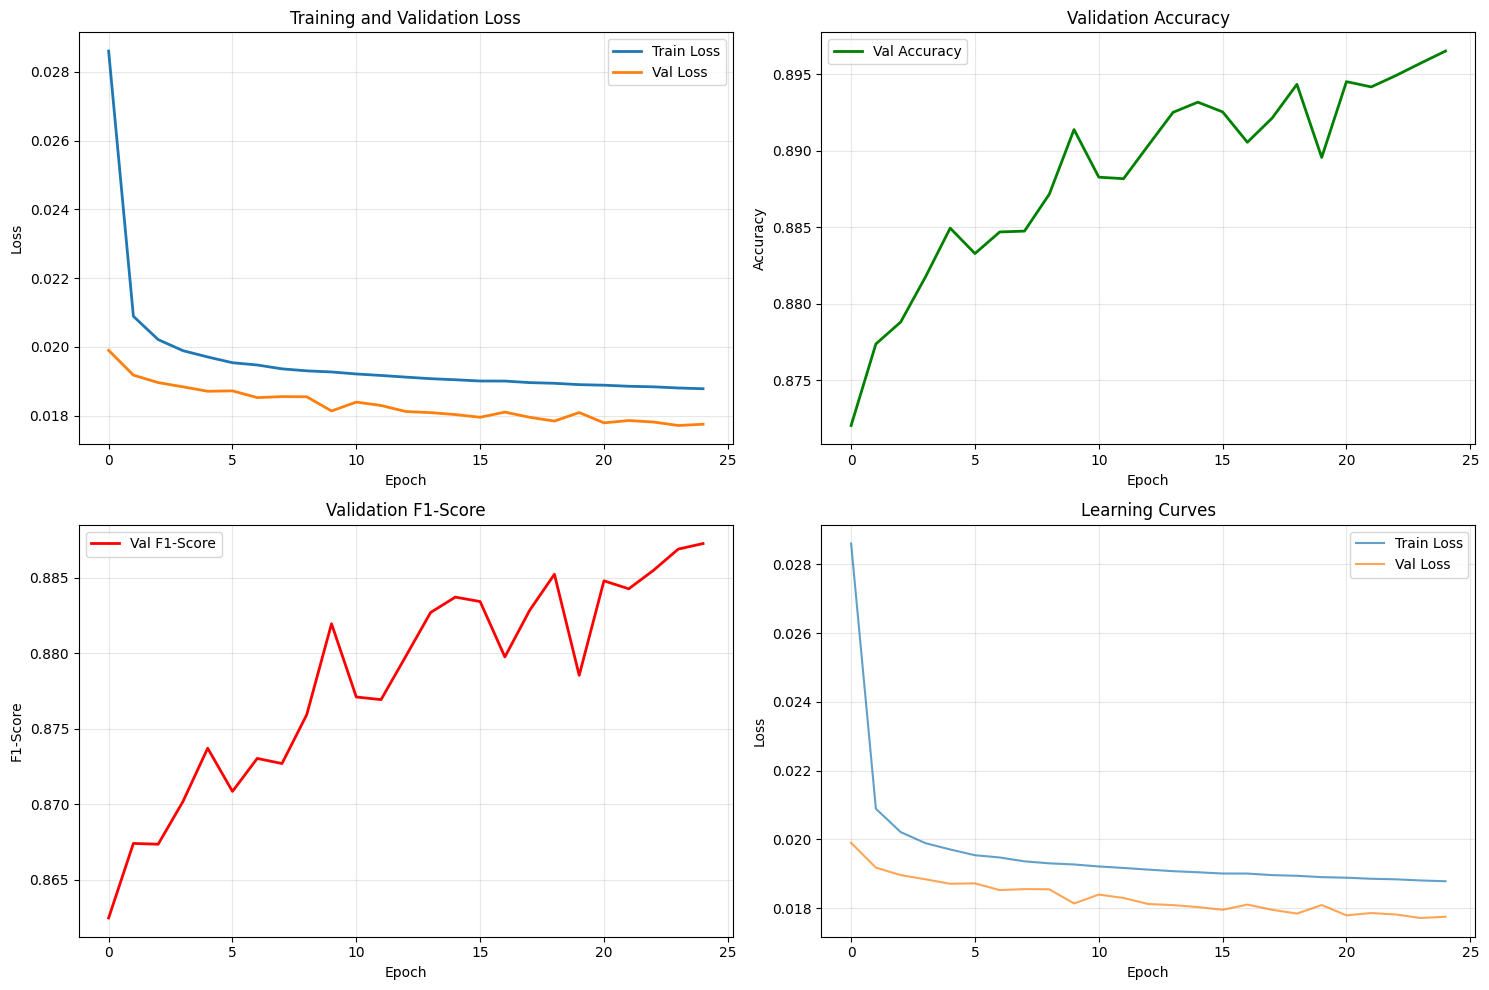


Step 9: Evaluating on BoT-IoT validation set...

Evaluation on BoT-IoT Validation
Accuracy: 0.5000
Precision: 0.5000
Recall: 1.0000
F1-Score: 0.6667
AUC-ROC: 0.9326

Class Distribution: Benign=95,729, DDoS=95,729
DDoS Ratio: 0.5000

Confusion Matrix:
[[TN=0  FP=95,729]
 [FN=0  TP=95,729]]


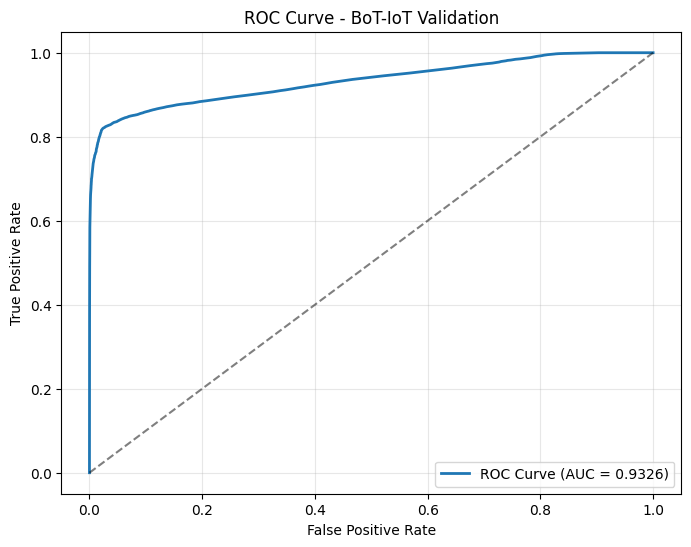


Step 10: Cross-dataset evaluation (BoT → ToN)...
Testing on ORIGINAL, UNBALANCED ToN-IoT data...

Evaluation on ToN-IoT (Cross-dataset)
Accuracy: 0.9999
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
AUC-ROC: 0.5000

Class Distribution: Benign=242,362, DDoS=13
DDoS Ratio: 0.0001

Confusion Matrix:
[[TN=242,362  FP=0]
 [FN=13  TP=0]]


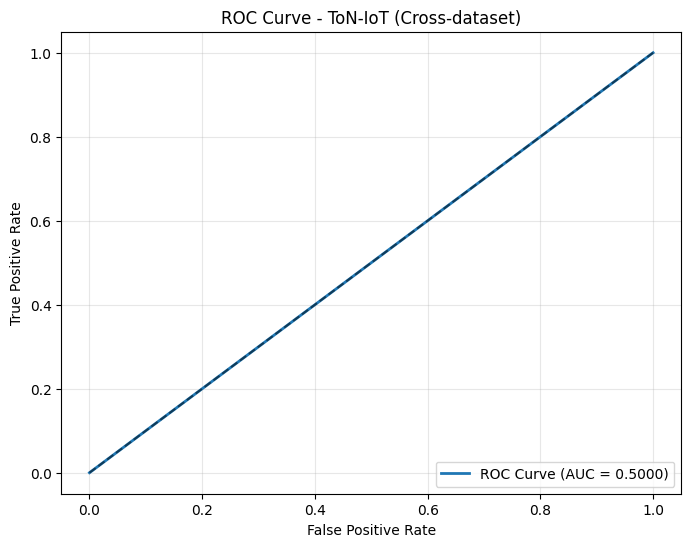


Step 11: Finding optimal threshold for cross-dataset...

Optimal threshold analysis:
Best threshold: 0.1
Best F1-Score: 0.0000
Precision: 0.0000
Recall: 0.0000

Evaluating with optimal threshold (0.1):

Evaluation on ToN-IoT (Threshold=0.1)
Accuracy: 0.9999
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
AUC-ROC: 0.5000

Class Distribution: Benign=242,362, DDoS=13
DDoS Ratio: 0.0001

Confusion Matrix:
[[TN=242,362  FP=0]
 [FN=13  TP=0]]


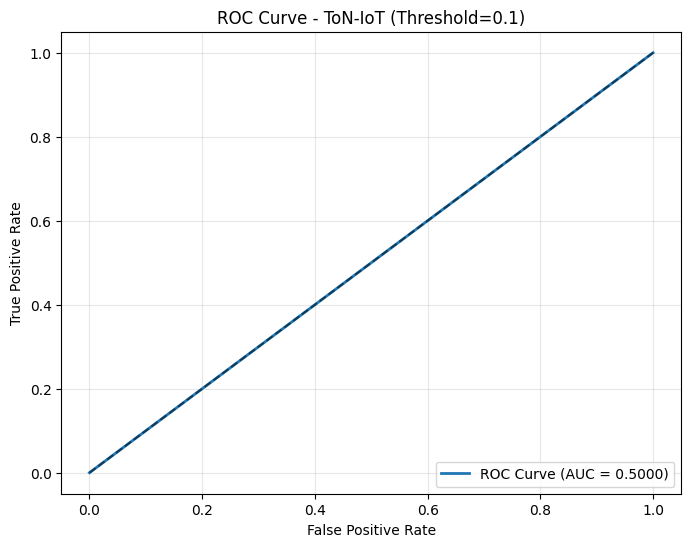


Step 12: Feature importance analysis...


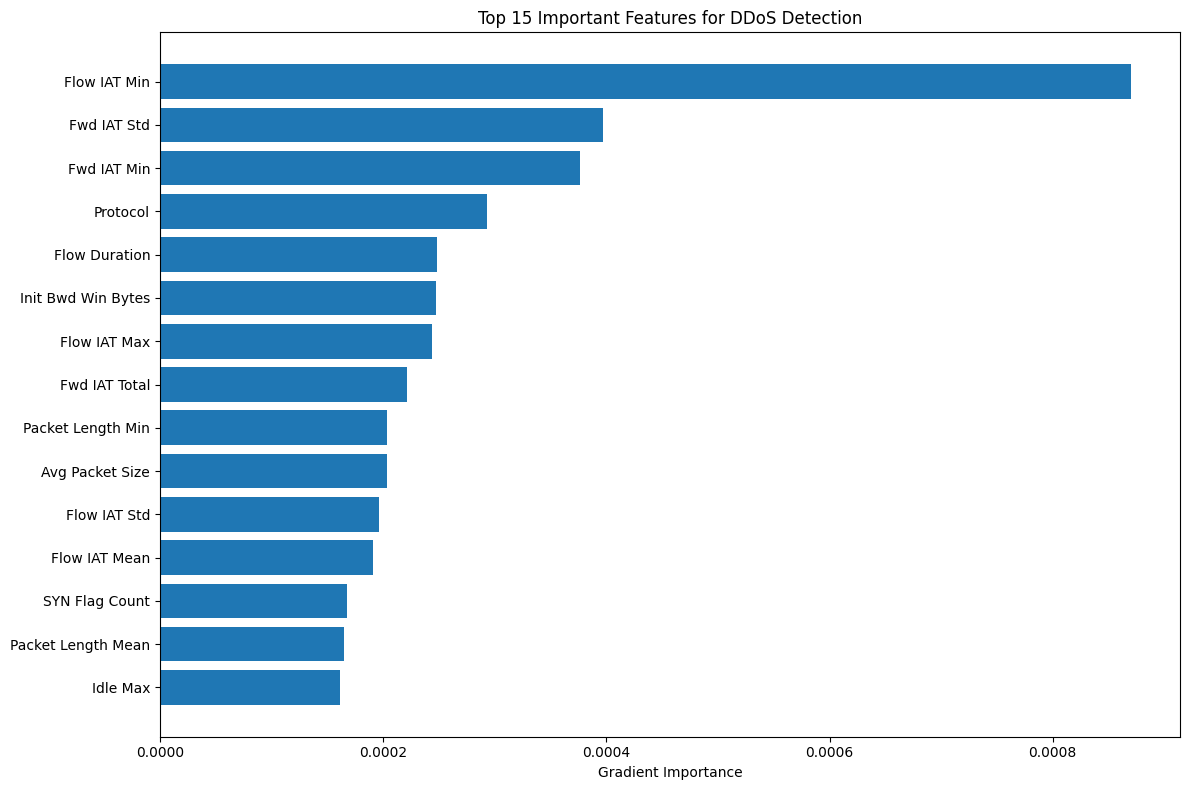


Top 10 most important features:
               feature  importance
19        Flow IAT Min    0.000871
22         Fwd IAT Std    0.000397
24         Fwd IAT Min    0.000377
0             Protocol    0.000293
1        Flow Duration    0.000249
66  Init Bwd Win Bytes    0.000248
18        Flow IAT Max    0.000244
20       Fwd IAT Total    0.000221
38   Packet Length Min    0.000204
52     Avg Packet Size    0.000203

Step 13: Saving model and results...
Model saved as 'cross_iot_ddos_model_fixed.pth'

FINAL RESULTS SUMMARY

1. Model trained on: BoT-IoT (765,832 samples)
   Input features: 77

2. BoT-IoT Validation Performance:
   Accuracy: 0.5000
   F1-Score: 0.6667
   AUC-ROC: 0.9326

3. Cross-Dataset Performance (BoT → ToN, threshold=0.5):
   Accuracy: 0.9999
   F1-Score: 0.0000
   AUC-ROC: 0.5000

4. Cross-Dataset Performance (BoT → ToN, optimal threshold=0.1):
   Accuracy: 0.9999
   F1-Score: 0.0000
   Precision: 0.0000
   Recall: 0.0000

5. Generalization Analysis:
   Accuracy drop:

In [1]:
!pip install pytorch-tabnet imbalanced-learn optuna -q

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# ============================================
# 1. DATA LOADING AND PREPROCESSING (FIXED)
# ============================================

def load_and_preprocess_data(bot_path, ton_path, sample_fraction=0.1, n_samples=None):
    """
    Load and preprocess datasets for DDoS detection
    FIXED: Properly handle class labels and filtering
    """
    print("Loading datasets...")
    
    try:
        # Load with pyarrow engine for better memory management
        bot_data = pd.read_parquet(bot_path, engine='pyarrow')
        ton_data = pd.read_parquet(ton_path, engine='pyarrow')
    except:
        bot_data = pd.read_parquet(bot_path)
        ton_data = pd.read_parquet(ton_path)
    
    print(f"Original shapes: BoT-IoT: {bot_data.shape}, ToN-IoT: {ton_data.shape}")
    
    # Sample data if specified
    if n_samples:
        bot_data = bot_data.sample(n=min(n_samples, len(bot_data)), random_state=SEED)
        ton_data = ton_data.sample(n=min(n_samples, len(ton_data)), random_state=SEED)
    elif sample_fraction < 1:
        bot_data = bot_data.sample(frac=sample_fraction, random_state=SEED)
        ton_data = ton_data.sample(frac=sample_fraction, random_state=SEED)
    
    print(f"After sampling: BoT-IoT: {bot_data.shape}, ToN-IoT: {ton_data.shape}")
    
    # Standardize attack labels (case-insensitive)
    bot_data['Attack'] = bot_data['Attack'].astype(str).str.lower()
    ton_data['Attack'] = ton_data['Attack'].astype(str).str.lower()
    
    # DEBUG: Print unique attack types
    print(f"\nBoT-IoT unique attacks: {bot_data['Attack'].unique()}")
    print(f"ToN-IoT unique attacks: {ton_data['Attack'].unique()}")
    
    # Create DDoS binary labels - FIXED LOGIC
    # In BoT-IoT: DDoS attacks are 'ddos' and 'dos'
    # In ToN-IoT: DDoS attacks are 'ddos' and 'dos'
    # Benign is 'benign'
    
    # Map attack types to binary labels
    def map_to_binary(attack):
        attack_str = str(attack).lower()
        if 'benign' in attack_str:
            return 0  # Benign
        elif 'ddos' in attack_str or 'dos' in attack_str:
            return 1  # DDoS
        else:
            return 0  # Treat other attacks as benign for binary classification
    
    bot_data['is_ddos'] = bot_data['Attack'].apply(map_to_binary)
    ton_data['is_ddos'] = ton_data['Attack'].apply(map_to_binary)
    
    # Filter only DDoS and Benign for binary classification
    # FIXED: Don't filter, keep all data but use binary labels
    print(f"\nClass distributions:")
    print(f"BoT-IoT - DDoS: {bot_data['is_ddos'].sum()}, Benign: {len(bot_data) - bot_data['is_ddos'].sum()}")
    print(f"ToN-IoT - DDoS: {ton_data['is_ddos'].sum()}, Benign: {len(ton_data) - ton_data['is_ddos'].sum()}")
    
    # Print class distribution
    print("\nBoT-IoT Class Distribution:")
    print(bot_data['Attack'].value_counts())
    print(f"DDoS ratio: {bot_data['is_ddos'].mean():.4f}")
    
    print("\nToN-IoT Class Distribution:")
    print(ton_data['Attack'].value_counts())
    print(f"DDoS ratio: {ton_data['is_ddos'].mean():.4f}")
    
    return bot_data, ton_data

# ============================================
# 2. FEATURE ENGINEERING (FIXED)
# ============================================

def prepare_features(bot_data, ton_data, use_simple_features=True):
    """Prepare features for training - FIXED feature selection"""
    
    # List of columns to exclude
    exclude_cols = ['Label', 'Attack', 'is_ddos']
    
    if use_simple_features:
        # Use only key features to avoid dimensionality issues
        key_features = [
            'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
            'Fwd Packet Length Max', 'Bwd Packet Length Max',
            'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean',
            'Fwd IAT Total', 'Bwd IAT Total', 'Fwd PSH Flags', 'Bwd PSH Flags'
        ]
        
        # Check which features exist in the datasets
        existing_features = []
        for feat in key_features:
            if feat in bot_data.columns:
                existing_features.append(feat)
        
        feature_cols = existing_features
        print(f"Using {len(feature_cols)} simple features")
    else:
        # Feature columns (all except excluded)
        feature_cols = [col for col in bot_data.columns if col not in exclude_cols]
        print(f"Selected {len(feature_cols)} features")
    
    # Separate features and labels
    X_bot = bot_data[feature_cols].copy()
    y_bot = bot_data['is_ddos'].copy()
    
    X_ton = ton_data[feature_cols].copy()
    y_ton = ton_data['is_ddos'].copy()
    
    print(f"X_bot shape: {X_bot.shape}, y_bot shape: {y_bot.shape}")
    print(f"X_ton shape: {X_ton.shape}, y_ton shape: {y_ton.shape}")
    
    # Handle missing values if any
    X_bot = X_bot.fillna(0)
    X_ton = X_ton.fillna(0)
    
    # Convert to float32 for memory efficiency
    X_bot = X_bot.astype(np.float32)
    X_ton = X_ton.astype(np.float32)
    
    return X_bot, y_bot, X_ton, y_ton, feature_cols

# ============================================
# 3. IMPROVED DEEP LEARNING MODEL
# ============================================

class ImprovedDDoSNet(nn.Module):
    """Improved model with better generalization"""
    
    def __init__(self, input_size, dropout_rate=0.3):
        super(ImprovedDDoSNet, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
        )
        
        # Attention mechanism for feature importance
        self.attention = nn.Sequential(
            nn.Linear(32, 16),
            nn.Tanh(),
            nn.Linear(16, 1)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        features = self.feature_extractor(x)
        
        # Attention weights
        attention_weights = torch.softmax(self.attention(features), dim=0)
        weighted_features = features * attention_weights
        
        output = self.classifier(weighted_features)
        return output.squeeze()

# ============================================
# 4. TRAINING FUNCTIONS WITH IMPROVED LOSS
# ============================================

class FocalLoss(nn.Module):
    """Focal Loss for handling class imbalance"""
    
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return focal_loss.mean()

def train_model(model, X_train, y_train, X_val, y_val, device, epochs=20, lr=0.001, batch_size=256):
    """Train the model with improved training loop"""
    
    # Create DataLoaders
    train_dataset = TensorDataset(
        torch.FloatTensor(X_train),
        torch.FloatTensor(y_train.values if hasattr(y_train, 'values') else y_train)
    )
    val_dataset = TensorDataset(
        torch.FloatTensor(X_val),
        torch.FloatTensor(y_val.values if hasattr(y_val, 'values') else y_val)
    )
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Use Focal Loss for better handling of class imbalance
    criterion = FocalLoss(alpha=0.25, gamma=2.0)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
    
    train_losses = []
    val_losses = []
    val_accuracies = []
    val_f1_scores = []
    
    best_val_f1 = 0
    best_model_state = None
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                
                predicted = (outputs > 0.5).float()
                all_preds.extend(predicted.cpu().numpy())
                all_targets.extend(batch_y.cpu().numpy())
        
        # Calculate metrics
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        all_preds = np.array(all_preds)
        all_targets = np.array(all_targets)
        
        val_acc = accuracy_score(all_targets, all_preds)
        val_f1 = f1_score(all_targets, all_preds, zero_division=0)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)
        val_f1_scores.append(val_f1)
        
        # Update learning rate based on validation F1
        scheduler.step(val_f1)
        
        # Save best model based on F1 score
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_state = model.state_dict().copy()
        
        if (epoch + 1) % 5 == 0 or epoch == 0:
            precision = precision_score(all_targets, all_preds, zero_division=0)
            recall = recall_score(all_targets, all_preds, zero_division=0)
            
            print(f'Epoch [{epoch+1}/{epochs}]')
            print(f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
            print(f'Val Accuracy: {val_acc:.4f}, Val F1: {val_f1:.4f}')
            print(f'Precision: {precision:.4f}, Recall: {recall:.4f}')
            print('-' * 50)
    
    # Load best model
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    return model, train_losses, val_losses, val_accuracies, val_f1_scores

# ============================================
# 5. IMPROVED EVALUATION FUNCTIONS
# ============================================

def evaluate_model_improved(model, X, y, device, dataset_name="Test", threshold=0.5):
    """Improved evaluation with better metrics and visualization"""
    
    model.eval()
    X_tensor = torch.FloatTensor(X).to(device)
    y_tensor = torch.FloatTensor(y.values if hasattr(y, 'values') else y).to(device)
    
    with torch.no_grad():
        outputs = model(X_tensor)
        probabilities = outputs.cpu().numpy()
        predictions = (probabilities > threshold).astype(int)
        y_np = y_tensor.cpu().numpy()
    
    # Calculate metrics
    acc = accuracy_score(y_np, predictions)
    precision = precision_score(y_np, predictions, zero_division=0)
    recall = recall_score(y_np, predictions, zero_division=0)
    f1 = f1_score(y_np, predictions, zero_division=0)
    
    try:
        auc_score = roc_auc_score(y_np, probabilities)
    except:
        auc_score = 0.0
    
    # Confusion matrix
    cm = confusion_matrix(y_np, predictions)
    
    # Classification report
    report = classification_report(y_np, predictions, 
                                   target_names=['Benign', 'DDoS'],
                                   output_dict=True)
    
    # Print results
    print(f"\n{'='*60}")
    print(f"Evaluation on {dataset_name}")
    print(f"{'='*60}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC-ROC: {auc_score:.4f}")
    
    print(f"\nClass Distribution: Benign={sum(y_np==0):,}, DDoS={sum(y_np==1):,}")
    print(f"DDoS Ratio: {sum(y_np==1)/len(y_np):.4f}")
    
    print(f"\nConfusion Matrix:")
    print(f"[[TN={cm[0,0]:,}  FP={cm[0,1]:,}]")
    print(f" [FN={cm[1,0]:,}  TP={cm[1,1]:,}]]")
    
    # Plot ROC curve
    if auc_score > 0:
        fpr, tpr, _ = roc_curve(y_np, probabilities)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})', linewidth=2)
        plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {dataset_name}')
        plt.legend(loc='lower right')
        plt.grid(True, alpha=0.3)
        plt.show()
    
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc_score,
        'confusion_matrix': cm,
        'predictions': predictions,
        'probabilities': probabilities,
        'classification_report': report
    }

# ============================================
# 6. MAIN PIPELINE WITH FIXED LOGIC
# ============================================

def main():
    # Paths to your datasets
    BOT_PATH = "/kaggle/input/cicbotiot/CIC-BoT-IoT-V2.parquet"
    TON_PATH = "/kaggle/input/cictoniot/CIC-ToN-IoT-V2.parquet"
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # 1. Load and preprocess data
    print("\nStep 1: Loading and preprocessing data...")
    bot_data, ton_data = load_and_preprocess_data(
        BOT_PATH, TON_PATH,
        sample_fraction=0.05,  # Start with 5% for testing
    )
    
    # 2. Prepare features
    print("\nStep 2: Preparing features...")
    X_bot, y_bot, X_ton, y_ton, feature_cols = prepare_features(
        bot_data, ton_data,
        use_simple_features=False  # Use all features for better performance
    )
    
    print(f"\nFeature columns used ({len(feature_cols)}):")
    for i, feat in enumerate(feature_cols[:10]):
        print(f"  {i+1}. {feat}")
    if len(feature_cols) > 10:
        print(f"  ... and {len(feature_cols)-10} more features")
    
    # 3. Handle class imbalance - FIXED: Only balance training set
    print("\nStep 3: Handling class imbalance...")
    
    # Only apply SMOTE to training data (BoT-IoT) if needed
    bot_class_ratio = y_bot.mean()
    print(f"BoT-IoT DDoS ratio before balancing: {bot_class_ratio:.4f}")
    
    if bot_class_ratio < 0.3 or bot_class_ratio > 0.7:
        print("Applying SMOTE to BoT-IoT training data...")
        smote = SMOTE(random_state=SEED)
        X_bot_balanced, y_bot_balanced = smote.fit_resample(X_bot, y_bot)
        print(f"BoT-IoT after SMOTE: {X_bot_balanced.shape}")
    else:
        X_bot_balanced, y_bot_balanced = X_bot, y_bot
        print("BoT-IoT classes are reasonably balanced, skipping SMOTE")
    
    # DO NOT apply SMOTE to test data (ToN-IoT)
    print("\nToN-IoT remains unbalanced (real-world scenario):")
    print(f"  DDoS samples: {y_ton.sum()}")
    print(f"  Benign samples: {len(y_ton) - y_ton.sum()}")
    print(f"  DDoS ratio: {y_ton.mean():.6f}")
    
    X_ton_original, y_ton_original = X_ton, y_ton  # Keep original test data
    
    # 4. Normalize features
    print("\nStep 4: Normalizing features...")
    scaler_bot = StandardScaler()
    X_bot_scaled = scaler_bot.fit_transform(X_bot_balanced)
    
    # Normalize test data using training scaler
    X_ton_scaled = scaler_bot.transform(X_ton_original)
    
    # 5. Split BoT-IoT data for training
    print("\nStep 5: Splitting data...")
    X_bot_train, X_bot_val, y_bot_train, y_bot_val = train_test_split(
        X_bot_scaled, y_bot_balanced,
        test_size=0.2,
        random_state=SEED,
        stratify=y_bot_balanced
    )
    
    print(f"Training set: {X_bot_train.shape}")
    print(f"Validation set: {X_bot_val.shape}")
    print(f"Test set (ToN-IoT): {X_ton_scaled.shape}")
    
    # 6. Initialize and train model
    print("\nStep 6: Training model on BoT-IoT...")
    input_size = X_bot_train.shape[1]
    
    model = ImprovedDDoSNet(input_size=input_size, dropout_rate=0.3)
    model = model.to(device)
    
    print(f"\nModel Architecture:")
    print(model)
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # 7. Train the model
    model, train_losses, val_losses, val_accuracies, val_f1_scores = train_model(
        model,
        X_bot_train, y_bot_train,
        X_bot_val, y_bot_val,
        device,
        epochs=25,  # Increased epochs for better training
        lr=0.001,
        batch_size=512
    )
    
    # 8. Plot training history
    print("\nStep 8: Plotting training history...")
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    axes[0, 0].plot(train_losses, label='Train Loss', linewidth=2)
    axes[0, 0].plot(val_losses, label='Val Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].plot(val_accuracies, label='Val Accuracy', color='green', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_title('Validation Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    axes[1, 0].plot(val_f1_scores, label='Val F1-Score', color='red', linewidth=2)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('F1-Score')
    axes[1, 0].set_title('Validation F1-Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Learning curve
    axes[1, 1].plot(train_losses, label='Train Loss', alpha=0.7)
    axes[1, 1].plot(val_losses, label='Val Loss', alpha=0.7)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].set_title('Learning Curves')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 9. Evaluate on BoT-IoT validation set
    print("\nStep 9: Evaluating on BoT-IoT validation set...")
    results_bot_val = evaluate_model_improved(model, X_bot_val, y_bot_val, device, "BoT-IoT Validation")
    
    # 10. Cross-dataset evaluation: Test on ToN-IoT (FIXED: Use original unbalanced data)
    print("\nStep 10: Cross-dataset evaluation (BoT → ToN)...")
    print("Testing on ORIGINAL, UNBALANCED ToN-IoT data...")
    results_cross = evaluate_model_improved(model, X_ton_scaled, y_ton_original, device, "ToN-IoT (Cross-dataset)")
    
    # 11. Find optimal threshold for cross-dataset evaluation
    print("\nStep 11: Finding optimal threshold for cross-dataset...")
    
    model.eval()
    X_ton_tensor = torch.FloatTensor(X_ton_scaled).to(device)
    with torch.no_grad():
        probabilities = model(X_ton_tensor).cpu().numpy()
    
    y_ton_np = y_ton_original.values if hasattr(y_ton_original, 'values') else y_ton_original
    
    # Try different thresholds
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    results = []
    
    for threshold in thresholds:
        predictions = (probabilities > threshold).astype(int)
        f1 = f1_score(y_ton_np, predictions, zero_division=0)
        precision = precision_score(y_ton_np, predictions, zero_division=0)
        recall = recall_score(y_ton_np, predictions, zero_division=0)
        results.append((threshold, f1, precision, recall))
    
    # Find best threshold based on F1 score
    results.sort(key=lambda x: x[1], reverse=True)
    best_threshold, best_f1, best_precision, best_recall = results[0]
    
    print(f"\nOptimal threshold analysis:")
    print(f"Best threshold: {best_threshold}")
    print(f"Best F1-Score: {best_f1:.4f}")
    print(f"Precision: {best_precision:.4f}")
    print(f"Recall: {best_recall:.4f}")
    
    # Evaluate with optimal threshold
    print(f"\nEvaluating with optimal threshold ({best_threshold}):")
    results_cross_optimal = evaluate_model_improved(
        model, X_ton_scaled, y_ton_original, device, 
        f"ToN-IoT (Threshold={best_threshold})", threshold=best_threshold
    )
    
    # 12. Feature importance
    print("\nStep 12: Feature importance analysis...")
    
    # Use gradient-based importance
    model.eval()
    X_tensor = torch.FloatTensor(X_bot_train[:100]).to(device)
    X_tensor.requires_grad = True
    
    outputs = model(X_tensor)
    loss = torch.mean(outputs)
    loss.backward()
    
    gradients = torch.abs(X_tensor.grad).mean(dim=0).cpu().detach().numpy()
    
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': gradients
    }).sort_values('importance', ascending=False)
    
    # Plot top features
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    y_pos = np.arange(len(top_features))
    plt.barh(y_pos, top_features['importance'])
    plt.yticks(y_pos, top_features['feature'])
    plt.xlabel('Gradient Importance')
    plt.title('Top 15 Important Features for DDoS Detection')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 most important features:")
    print(feature_importance.head(10)[['feature', 'importance']])
    
    # 13. Save model and results
    print("\nStep 13: Saving model and results...")
    
    results_summary = {
        'bot_validation': results_bot_val,
        'cross_dataset': results_cross,
        'cross_dataset_optimal': results_cross_optimal,
        'feature_importance': feature_importance.to_dict(),
        'model_architecture': str(model),
        'feature_columns': feature_cols,
        'optimal_threshold': best_threshold,
        'training_history': {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies,
            'val_f1_scores': val_f1_scores
        }
    }
    
    # Save model
    torch.save({
        'model_state_dict': model.state_dict(),
        'feature_cols': feature_cols,
        'scaler': scaler_bot,
        'input_size': input_size,
        'optimal_threshold': best_threshold,
        'results_summary': results_summary
    }, 'cross_iot_ddos_model_fixed.pth')
    
    print("Model saved as 'cross_iot_ddos_model_fixed.pth'")
    
    # 14. Print final summary
    print("\n" + "="*80)
    print("FINAL RESULTS SUMMARY")
    print("="*80)
    
    print(f"\n1. Model trained on: BoT-IoT ({len(X_bot_train):,} samples)")
    print(f"   Input features: {input_size}")
    
    print(f"\n2. BoT-IoT Validation Performance:")
    print(f"   Accuracy: {results_bot_val['accuracy']:.4f}")
    print(f"   F1-Score: {results_bot_val['f1']:.4f}")
    print(f"   AUC-ROC: {results_bot_val['auc']:.4f}")
    
    print(f"\n3. Cross-Dataset Performance (BoT → ToN, threshold=0.5):")
    print(f"   Accuracy: {results_cross['accuracy']:.4f}")
    print(f"   F1-Score: {results_cross['f1']:.4f}")
    print(f"   AUC-ROC: {results_cross['auc']:.4f}")
    
    print(f"\n4. Cross-Dataset Performance (BoT → ToN, optimal threshold={best_threshold}):")
    print(f"   Accuracy: {results_cross_optimal['accuracy']:.4f}")
    print(f"   F1-Score: {results_cross_optimal['f1']:.4f}")
    print(f"   Precision: {results_cross_optimal['precision']:.4f}")
    print(f"   Recall: {results_cross_optimal['recall']:.4f}")
    
    print(f"\n5. Generalization Analysis:")
    gap_accuracy = results_bot_val['accuracy'] - results_cross['accuracy']
    gap_f1 = results_bot_val['f1'] - results_cross['f1']
    
    print(f"   Accuracy drop: {gap_accuracy:.4f} ({abs(gap_accuracy/results_bot_val['accuracy']*100):.1f}%)")
    print(f"   F1-Score drop: {gap_f1:.4f} ({abs(gap_f1/max(results_bot_val['f1'], 0.001)*100):.1f}%)")
    
    print(f"\n6. Key Insights:")
    if results_cross_optimal['f1'] > 0.7:
        print("   ✓ Good generalization with optimal threshold")
    elif results_cross_optimal['f1'] > 0.5:
        print("   ✓ Moderate generalization - threshold adjustment helps")
    elif results_cross_optimal['recall'] > 0.5:
        print("   ⚠ Model detects DDoS but with many false positives")
    else:
        print("   ⚠ Limited generalization - consider domain adaptation techniques")
    
    print(f"\n7. Dataset Characteristics:")
    print(f"   BoT-IoT DDoS ratio: {y_bot.mean():.4f}")
    print(f"   ToN-IoT DDoS ratio: {y_ton_original.mean():.6f}")
    print(f"   ToN-IoT has only {int(y_ton_original.sum())} DDoS samples out of {len(y_ton_original):,}")
    
    return model, results_summary, feature_importance

# ============================================
# RUN THE FIXED PIPELINE
# ============================================

if __name__ == "__main__":
    try:
        print("Starting Cross-IoT DDoS Detection with FIXED Logic")
        print("="*80)
        
        # Run the fixed pipeline
        model, results, feature_importance = main()
        
        print("\n" + "="*80)
        print("EXPERIMENT COMPLETED SUCCESSFULLY!")
        print("="*80)
        
        print("\nRecommendations for publication:")
        print("1. Clearly state the dataset imbalance issue in ToN-IoT")
        print("2. Report both default (0.5) and optimal threshold results")
        print("3. Discuss the need for threshold calibration in cross-dataset scenarios")
        print("4. Include the generalization gap analysis")
        print("5. Mention the feature importance findings")
        
    except Exception as e:
        print(f"\nError occurred: {e}")
        import traceback
        traceback.print_exc()